In [1]:
#configure plotting
import ipympl
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)
import GPy
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(1)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Create dataset

In [2]:
import numpy as np
import math
import random

N = 100

def create_dataset(xmin,xmax,N):

    A0 = 1.0
       
    T1 = 3
    phi1 = 2*math.pi/float(T1)
    A1 = 1/phi1
    
    T2 = 6
    phi2 = 2*math.pi/float(T2)
    A2 = 1/phi2
    
    xt = np.linspace(xmin, xmax, N)
    yt = np.zeros(xt.shape)
    for i in xrange(N):
        yt[i] = A0 + A1*math.sin(phi1*xt[i]) + A2*math.cos(phi2*xt[i])

    samples = np.random.normal(1,0.001,N/2)
    idx = random.sample(range(N), N/2)

    xs = np.zeros((N,2))
    xs[0:N/2,1] = yt[idx]+samples 
    xs[0:N/2,0] = xt[idx]
    nidx = np.setdiff1d(np.arange(0,N,1),idx)
    xs[N/2:N,1] = yt[nidx]-samples 
    xs[N/2:N,0] = xt[nidx]

    ys = np.zeros((N,))
    ys[0:N/2] = 1

    idx = random.sample(range(N), N/2)
    x = xs[idx,:]
    y = ys[idx]
    
    nidx = np.setdiff1d(np.arange(0,N,1),idx)
    tidx = random.sample(nidx, N/5)
    x_tst = xs[tidx,:]
    y_tst = ys[tidx]
    
    print(list(set(idx).intersection(tidx)))
    
        
    return x, y, xt, yt, x_tst, y_tst


def create_grid(xmin, xmax, N):
    """
    Creates a grid for 3d plotting.
    :param xmin: lower limit
    :param xmax: upper limit
    :param N: number of points in the grid per dimension
    :return: the grid
    """

    xx = np.linspace(xmin, xmax, N)
    X, Y = np.meshgrid(xx, xx)
    data = np.concatenate([X.reshape([-1, 1]), Y.reshape([-1, 1])], axis=1)

    return data, X, Y



def show_train_data():
    """
    Plots the training data.
    """
    xmin = -10.0
    xmax = 10.0
    xs, ys, xt, yt, x_tst, y_tst = create_dataset(xmin,xmax,N)

    fig = plt.figure(figsize=(15,5)) 

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(xs[ys == 0, 0], xs[ys == 0, 1], 'b.', ms=12)
    ax1.plot(xs[ys == 1, 0], xs[ys == 1, 1], 'r.', ms=12)
    ax1.plot(xt,yt)
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.set_title('Training data')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(x_tst[y_tst == 0, 0], x_tst[y_tst == 0, 1], 'b.', ms=12)
    ax2.plot(x_tst[y_tst == 1, 0], x_tst[y_tst == 1, 1], 'r.', ms=12)
    ax2.plot(xt,yt)
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_title('Test data')

    
    
    plt.show()
    
    return xs, ys, xt, yt, x_tst, y_tst

[]


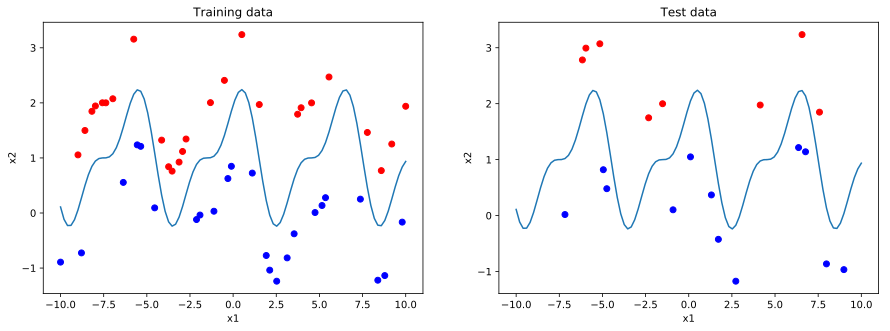

In [3]:
X_tr, Y_tr, xt, yt, x_tst_prescale, y_tst = show_train_data()

# Init GP

Create a Radial Basis Function (Gaussian) kernel. In this case, we assume that a hidden function f, drawn from the GP, generates values that next get squashed to [0,1] and the prediction is conditioned on those. (this is to generate training targets if we do not have a given dataset).

In [ ]:
l = 0.05
k = GPy.kern.RBF(2, variance=10, lengthscale=l)
print(k.K(X_tr).shape)
#print(X_tr.shape)
#X_tr = np.random.rand(50,1)
#draw the latent function value
#f = np.random.multivariate_normal(np.zeros(X_tr.shape[0]),k.K(X_tr))

plt.plot(X_tr, f, 'bo')
plt.title('latent function values');plt.xlabel('$x$');plt.ylabel('$f(x)$')

# Bernoulli samples

Now squash the f values and then we sample from a Bernoulli distribution conditioned on the squashed probits.

In [ ]:
lik = GPy.likelihoods.Bernoulli()
p = lik.gp_link.transf(f) # squash the latent function
plt.plot(X_tr, p, 'ro')
plt.title('latent probabilities');plt.xlabel('$x$');plt.ylabel('$\sigma(f(x))$')

In [ ]:
Y_tr = lik.samples(f).reshape(-1,1)
plt.plot(X_tr, Y_tr, 'kx', mew=2);
plt.ylim(-0.1, 1.1)
plt.title('Bernoulli draws');plt.xlabel('$x$');plt.ylabel('$y \in \{0,1\}$')


In [ ]:
"""
m = GPy.core.GP(X=X_tr[:,1].reshape(-1,1),
                Y=Y_tr, 
                kernel=k, 
                inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
                likelihood=lik)
print m
"""

In [ ]:
m = GPy.models.GPClassification(X_tr,Y_tr.reshape(-1,1),kernel=k)
#k = GPy.kern.RBF(1, variance=1., lengthscale=l)

#m = GPy.core.GP(X=X_tr,
#                Y=Y_tr.reshape(-1,1), 
#                kernel=k, 
#                inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
#                likelihood=lik)

fig = m.plot(plot_density=True)
#plt.plot(X_tr, p, 'ro')
#plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$')

m.plot_f(plot_density=True)
#plt.plot((X_tr), f, 'bo')
#plt.ylabel('$f(x)$');plt.xlabel('$x$')

In [ ]:
print m, '\n'
for i in range(10):
    m.optimize('bfgs', max_iters=100) #first runs EP and then optimizes the kernel parameters
    print 'iteration:', i,
    print m
    print ""
    
m.plot(plot_density=True)
#plt.plot(X_tr, p, 'ro', label='Truth')
#plt.ylabel('$y, p(y=1)$');plt.xlabel('$x$')
plt.legend()
m.plot_f(plot_density=True)
#plt.plot(X_tr, f, 'bo', label='Truth')
#plt.ylabel('$f(x)$');plt.xlabel('$x$')
#plt.legend()

In [ ]:
probs = m.predict_quantiles(x_tst_prescale)
#print(probs)
res = GPy.util.classification.conf_matrix(probs[0], y_tst.reshape(-1,1))


# Remarks

Assumption on input: data come from a Gaussian distribution with covariance as given by the kernel function. In our case, data are non-Gaussian, hence the difficulty to fit a GP on them.  (?????)

In [ ]:
"""
print m, '\n'
for i in range(10):
    m.optimize('bfgs', max_iters=100) #first runs EP and then optimizes the kernel parameters
    print 'iteration:', i,
    print m
    print ""
"""

# Approximate GPs with variational dropout

Kernel function as in Gal

Input : N x Q 
Parameter W : Q x K (k_dim) 

In [145]:
from GPy.kern import Kern
from GPy.util.linalg import tdot
from GPy.core.parameterization import Param
from paramz.caching import Cache_this
from GPy.util.squashers import sigmoid
from paramz.transformations import Logexp

class SigmoidSumProd(Kern):
   

    def __init__(self, input_dim, k_dim, variances=None, biases=0., ARD=False, active_dims=None, name='sigmoidss'):
        super(SigmoidSumProd, self).__init__(input_dim, active_dims, name)
        self.ARD = ARD
        self._all_dims_active = None 
        self.k_dim = k_dim
        
        """
        if not ARD:
            if variances is not None:
                variances = np.asarray(variances)
                assert variances.size == 1, "Only one variance needed for non-ARD kernel"
            else:
                variances = np.ones((self.input_dim,self.k_dim))
            if biases is not None:
                biases = np.asarray(biases)
                assert biases.size == 1, "Only one bias needed for non-ARD kernel"
            else:
                biases = np.zeros((1,))
                
        else:
            if variances is not None:
                variances = np.asarray(variances)
                assert variances.size == self.input_dim, "bad number of variances, need one ARD variance per input_dim"
            else:
                variances = np.ones((self.input_dim,self.k_dim))
            if biases is not None:
                biases = np.asarray(biases)
                assert biases.size == self.k_dim, "bad number of biases, need one bias per k_dim"
            else:
                biases = np.zeros((1,))
        """      
                
        self.variances = Param('variances', variances)
        self.biases = Param('biases', biases)
        self.link_parameters(self.variances, self.biases)
        
    def to_dict(self):
        input_dict = super(SigmoidSumProd, self)._to_dict()
        input_dict["class"] = "GPy.kern.SigoidSumProd"
        input_dict["variances"] = self.variances.values.tolist()
        input_dict["biases"] = self.biases.values.tolist()
        input_dict["ARD"] = self.ARD
        return input_dict

    @staticmethod
    def _from_dict(kernel_class, input_dict):
        useGPU = input_dict.pop('useGPU', None)
        return SigmoidSumProd(**input_dict)

    @Cache_this(limit=3)
    def K(self, X, X2=None):
            if X2 is None:
               X2 = X
            #cov = np.zeros((X.shape[0],X2.shape[0]))
            #cov[:,:] = self._dot_product(sigmoid(self._dot_product(self.variances.T,X).T), sigmoid(self._dot_product(self.variances.T,X2).T))
            cov = self._dot_product(sigmoid(self.variances*X+self.biases), sigmoid(self.variances*X2+self.biases))
            
            return cov
        
    @Cache_this(limit=3, ignore_args=(0,))
    def _dot_product(self, X, X2=None):
        if X2 is None:
            return tdot(X)
        else:
            return np.dot(X, X2.T)

    def Kdiag(self, X):
        cov = np.zeros(X.shape[0])
        for i in xrange(X.shape[0]):
            cov[i] = self._dot_product(sigmoid(self.variances*X[i,:]+self.biases))
           
        return cov

    def update_gradients_full(self, dL_dK, X, X2=None):
        if X2 is None:
            X2 = X
              
        s1   = sigmoid(self.variances*X+self.biases)     
        s2   = sigmoid(self.variances*X2+self.biases)
        a1   = (np.exp(-1*self.variances*X-self.biases)/(1+np.exp(-1*self.variances*X-self.biases))**2)*X
        a2   = (np.exp(-1*self.variances*X2-self.biases)/(1+np.exp(-1*self.variances*X2-self.biases))**2)*X2
        grad = a1.dot(s2.T) + s1.dot(a2.T)
        #print(s1.shape)
        #print(a1.shape)
        #print(grad)
        self.variances.gradient = (dL_dK*grad).sum()
        
        a1   = np.exp(-1*self.variances*X-self.biases)/(1+np.exp(-1*self.variances*X-self.biases))**2
        a2   = np.exp(-1*self.variances*X2-self.biases)/(1+np.exp(-1*self.variances*X2-self.biases))**2
        grad = a1.dot(s2.T)+s1.dot(a2.T)
        self.biases.gradient = (dL_dK*grad).sum()

    def parameters_changed(self):
        """
        print("Optimising...")
        """
        pass
    
def test_kernel(kernel,X):
    print(kernel.randomize())
    assert GPy.testing.kernel_tests.check_kernel_gradient_functions(kernel, X=X, X2=X, verbose=True)

# Create GP model for classification and plot initial fit on training data

                   Name                   |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
--------------------------------------------------------------------------------------------------------------------------
 gp_classification.sigmoidss.variances    |   1.000000    |   0.000000    |   0.152709    |   0.152709    |     8e-09     
 gp_classification.sigmoidss.biases       |   1.000000    |   0.000000    |   1.926292    |   1.926292    |     1e-07     
True

Name : gp_classification
Objective : 37.5681682299
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.   |  value  |  constraints  |  priors 
  sigmoidss.variances  |    7.0  |               |  N(0, 7)
  sigmoidss.biases     |    0.0  |               |  N(0, 1)


Text(0.5,0,'$x$')

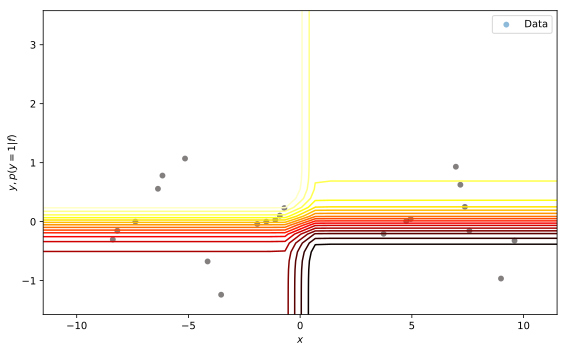

In [157]:
import GPy.testing.kernel_tests as ut
from GPy.models import GradientChecker

#kc = MLP2(2,ARD=True)
kc = SigmoidSumProd(input_dim=2, k_dim=3, variances=7., biases=0., active_dims=None)
kernel = kc
m = GPy.models.GPClassification(X_tr,Y_tr.reshape(-1,1),kernel=kernel)
m.kern.variances.set_prior(GPy.priors.Gaussian(0.,7.))
m.kern.biases.set_prior(GPy.priors.Gaussian(0,1.))

print(m.checkgrad(verbose=True))
print(m)
fig = m.plot()
plt.ylabel('$y, p(y=1|f)$');plt.xlabel('$x$')



#print(test_kernel(kernel,X_tr))


In [158]:
"""
print(kernel.K(np.array([[1,1]])))
print(kernel.update_gradients_full(1,np.array([[1,1]])))

X = np.random.randn(N,2)
kern = kernel
grad = GradientChecker(kern.K, lambda x: kern.update_gradients_full(np.ones((1,1)), x),x0 = X.copy(),names='X')
grad.checkgrad(verbose=1)
grad.randomize()
grad.checkgrad(verbose=1)
"""

"\nprint(kernel.K(np.array([[1,1]])))\nprint(kernel.update_gradients_full(1,np.array([[1,1]])))\n\nX = np.random.randn(N,2)\nkern = kernel\ngrad = GradientChecker(kern.K, lambda x: kern.update_gradients_full(np.ones((1,1)), x),x0 = X.copy(),names='X')\ngrad.checkgrad(verbose=1)\ngrad.randomize()\ngrad.checkgrad(verbose=1)\n"

## Optimise GP

In [159]:
print m, '\n'
for i in range(10):
    m.optimize('bfgs', max_iters=15) #first runs EP and then optimizes the kernel parameters
    print 'iteration:', i,
    print m
    print ""




Name : gp_classification
Objective : 37.5681682299
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.   |  value  |  constraints  |  priors 
  sigmoidss.variances  |    7.0  |               |  N(0, 7)
  sigmoidss.biases     |    0.0  |               |  N(0, 1) 

iteration: 0 
Name : gp_classification
Objective : 33.3701793207
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.   |               value  |  constraints  |  priors 
  sigmoidss.variances  |   2.659038068847273  |               |  N(0, 7)
  sigmoidss.biases     |  -1.942969384099147  |               |  N(0, 1)

iteration: 1 
Name : gp_classification
Objective : 33.0102551834
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.   |               value  |  constraints  |  priors 
  sigmoidss.variances  |   2.615678245374148  |               |  N(0, 7)


# Plot GP fit and latent fit after optimisation

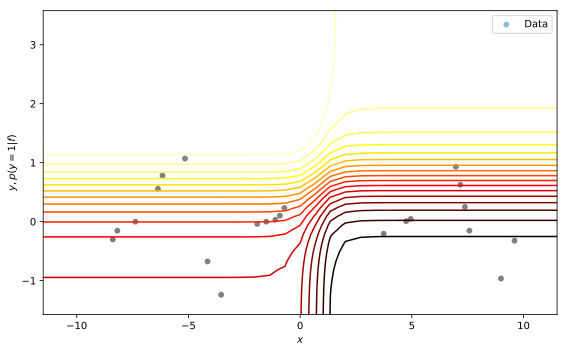

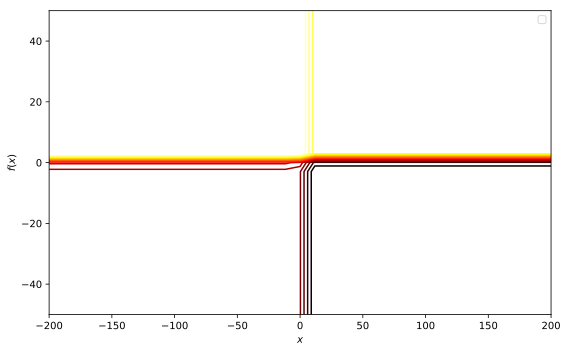

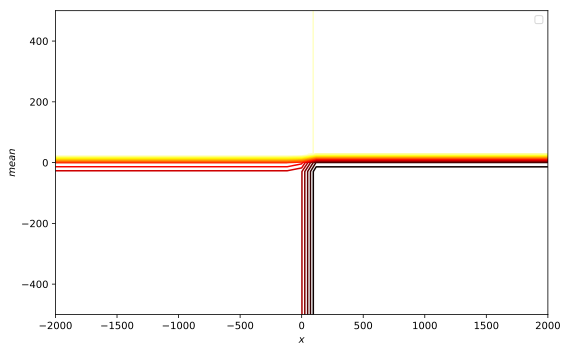

In [160]:
fig = m.plot(plot_data=True)
plt.ylabel('$y, p(y=1|f)$');plt.xlabel('$x$')
plt.legend()
m.plot_f(plot_data=True,plot_limits=[[-200,-50],[200,50]])
plt.ylabel('$f(x)$');plt.xlabel('$x$')
plt.legend()
m.plot_mean(plot_data=True,plot_limits=[[-2000,-500],[2000,500]])
plt.ylabel('$mean$');plt.xlabel('$x$')
plt.legend()






# Evaluate fit on test set and plot confusion matrix

In [161]:
probs = m.predict(x_tst_prescale)
#print(probs)
res = GPy.util.classification.conf_matrix(probs[0], y_tst.reshape(-1,1))


(65.0, '% instances correctly classified')
          |  1         |  0         | 
----------|------------|------------|
1         |  10.0      |  0         | 
0         |  7         |  3.0       | 
